Loaded data shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Missing values per column:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThic

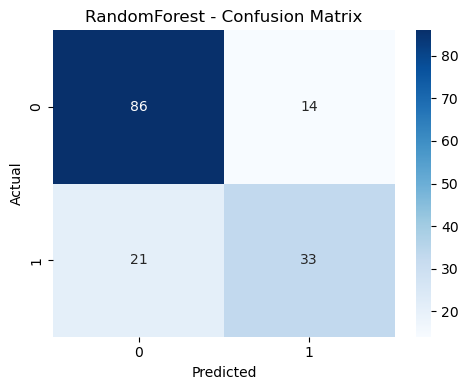

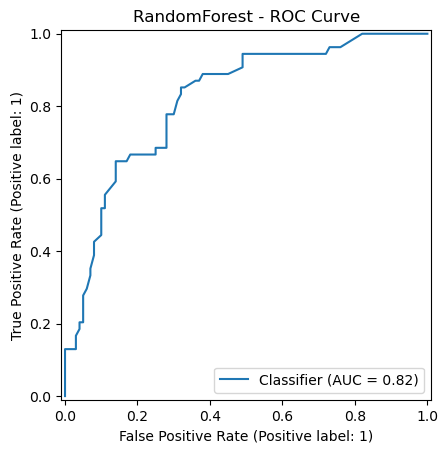

ROC AUC: 0.8180555555555555

Saved best model pipeline to best_diabetes_model.joblib


In [1]:
# diabetes_predictor.py
"""
Diabetes prediction ML script.
Assumes CSV filename: "diabetes data set.csv" in same folder.
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix,
                             RocCurveDisplay)

import joblib

# -------------------------
# 1. Load dataset
# -------------------------
FNAME = "diabetes data set.csv"   # change if needed

if not os.path.exists(FNAME):
    raise FileNotFoundError(f"File not found: {FNAME}. Put your CSV in the same folder or update FNAME.")

df = pd.read_csv(FNAME)
print("Loaded data shape:", df.shape)
print("Columns:", list(df.columns))

# -------------------------
# 2. Quick EDA / check
# -------------------------
print("\nFirst 5 rows:")
print(df.head())

print("\nMissing values per column:")
print(df.isnull().sum())

# If dataset uses 0 as missing for certain medical columns (like Pima dataset),
# replace zeros with NaN for selected columns:
possible_zero_na_cols = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
# Only apply if such columns exist:
for c in possible_zero_na_cols:
    if c in df.columns:
        # Many datasets use 0 meaning missing for these features
        zero_count = (df[c] == 0).sum()
        if zero_count > 0:
            print(f"Column {c} has {zero_count} zeros - treating zeros as missing (NaN).")
            df.loc[df[c] == 0, c] = np.nan

# -------------------------
# 3. Prepare features and target
# -------------------------
# Attempt to auto-detect target column: common names: 'Outcome','Diabetes','Target'
target_candidates = ['Outcome', 'Diabetes', 'target', 'Target', 'CLASS', 'Label']
target_col = None
for t in target_candidates:
    if t in df.columns:
        target_col = t
        break

# If still None, assume last column is target
if target_col is None:
    target_col = df.columns[-1]
    print(f"No common target name found. Using last column as target: '{target_col}'")

X = df.drop(columns=[target_col])
y = df[target_col]

# Basic type info
print("\nFeature dtypes:\n", X.dtypes)

# -------------------------
# 4. Split dataset
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}")

# -------------------------
# 5. Preprocessing pipeline
# -------------------------
# numeric columns
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
# if there are categorical columns, you could add handling; here we assume numeric features
print("Numeric columns used:", num_cols)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols)
], remainder='drop')  # drop non-numeric columns by default

# -------------------------
# 6. Model candidates and pipelines
# -------------------------
models = {
    'LogisticRegression': Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'RandomForest': Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
    ]),
    'SVM': Pipeline(steps=[
        ('pre', preprocessor),
        ('clf', SVC(kernel='rbf', probability=True, random_state=42))
    ])
}

# -------------------------
# 7. Train and evaluate each model (basic)
# -------------------------
results = {}
for name, pipe in models.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results[name] = {
        'pipeline': pipe,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    }

    print(f"{name} metrics: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC_AUC={roc if roc is None else f'{roc:.4f}'}")

# -------------------------
# 8. Pick best model (by F1, then ROC)
# -------------------------
best_name = None
best_score = -1
for name, r in results.items():
    score = r['f1']
    if score > best_score:
        best_score = score
        best_name = name

best = results[best_name]
print(f"\nSelected best model: {best_name} with F1={best_score:.4f}")

# -------------------------
# 9. Detailed evaluation & plots for best model
# -------------------------
best_pipe = best['pipeline']
y_pred_best = best_pipe.predict(X_test)
if hasattr(best_pipe.named_steps['clf'], "predict_proba"):
    y_prob_best = best_pipe.predict_proba(X_test)[:, 1]
else:
    # fall back to decision function if available
    if hasattr(best_pipe.named_steps['clf'], "decision_function"):
        df_scores = best_pipe.decision_function(X_test)
        # scale to [0,1] conservatively
        y_prob_best = (df_scores - df_scores.min()) / (df_scores.max() - df_scores.min() + 1e-9)
    else:
        y_prob_best = None

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print("\nConfusion matrix (rows: true, cols: pred):\n", cm)

# Display confusion matrix plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"{best_name} - Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

# ROC curve if probabilities available
if y_prob_best is not None:
    RocCurveDisplay.from_predictions(y_test, y_prob_best)
    plt.title(f"{best_name} - ROC Curve")
    plt.show()
    print("ROC AUC:", roc_auc_score(y_test, y_prob_best))

# -------------------------
# 10. Save the best model
# -------------------------
MODEL_OUT = "best_diabetes_model.joblib"
joblib.dump(best_pipe, MODEL_OUT)
print(f"\nSaved best model pipeline to {MODEL_OUT}")

# -------------------------
# 11. Example: predict on new sample(s)
# -------------------------
# If you want to predict on a new sample, create a dict with same feature names:
# new_sample = pd.DataFrame([{
#     'Pregnancies': 2, 'Glucose': 120, 'BloodPressure': 70, 'SkinThickness': 20,
#     'Insulin': 79, 'BMI': 25.1, 'DiabetesPedigreeFunction': 0.5, 'Age': 29
# }])
# pred = best_pipe.predict(new_sample)
# prob = best_pipe.predict_proba(new_sample)[:,1] if hasattr(best_pipe.named_steps['clf'], 'predict_proba') else None
# print("Pred:", pred, "Prob:", prob)


In [ ]:
"""
Flask web app for Diabetes Prediction
Save this file as `diabetes_web_app.py` next to your trained model `best_diabetes_model.joblib`.

Install dependencies:
    pip install flask pandas scikit-learn joblib numpy matplotlib

Run:
    python diabetes_web_app.py

Open: http://127.0.0.1:5000/

Features:
- Load saved pipeline `best_diabetes_model.joblib` and use it for predictions
- Single-sample prediction via form
- Batch prediction via CSV upload (CSV must contain the same feature columns used in training)
- Simple results table and downloadable CSV of predictions
"""

from flask import Flask, request, render_template_string, send_file, redirect, url_for, flash
import joblib
import pandas as pd
import io
import os
import numpy as np

app = Flask(__name__)
app.secret_key = 'replace-this-with-a-secure-key'

MODEL_PATH = 'best_diabetes_model.joblib'

# Minimal HTML template using Bootstrap CDN
TEMPLATE = '''
<!doctype html>
<html lang="en">
  <head>
    <meta charset="utf-8">
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <title>Diabetes Predictor</title>
    <link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.0/dist/css/bootstrap.min.css" rel="stylesheet">
  </head>
  <body class="bg-light">
    <div class="container py-5">
      <div class="card shadow-sm">
        <div class="card-body">
          <h1 class="card-title">Diabetes Prediction Web App</h1>
          <p class="text-muted">Use the form below to predict one sample, or upload a CSV for batch predictions.</p>

          {% with messages = get_flashed_messages() %}
            {% if messages %}
              <div class="alert alert-warning">{{ messages[0] }}</div>
            {% endif %}
          {% endwith %}

          <h5>Single sample prediction</h5>
          <form method="post" action="/predict" class="row g-2 align-items-end">
            {% for col in feature_cols %}
              <div class="col-md-3">
                <label class="form-label">{{ col }}</label>
                <input step="any" name="{{ col }}" class="form-control" required>
              </div>
            {% endfor %}
            <div class="col-12">
              <button class="btn btn-primary mt-2">Predict</button>
            </div>
          </form>

          <hr>

          <h5>Batch prediction (CSV)</h5>
          <form method="post" action="/upload" enctype="multipart/form-data">
            <div class="mb-2">
              <input class="form-control" type="file" name="file" accept=".csv" required>
            </div>
            <div class="mb-2">
              <button class="btn btn-success">Upload & Predict</button>
            </div>
            <div class="small text-muted">CSV should contain the feature columns: {{ feature_cols|join(', ') }}</div>
          </form>

          {% if single_result is defined %}
            <hr>
            <h5>Single prediction result</h5>
            <div class="alert alert-info">
              <strong>Predicted class:</strong> {{ single_result.pred }}
              {% if single_result.prob is not none %}
                <br><strong>Probability:</strong> {{ '%.3f'|format(single_result.prob) }}
              {% endif %}
            </div>
          {% endif %}

          {% if table_html is defined %}
            <hr>
            <h5>Batch results</h5>
            <div class="mb-2">{{ download_link|safe }}</div>
            <div class="table-responsive">{{ table_html|safe }}</div>
          {% endif %}

          <hr>
          <footer class="text-muted small">Make sure `best_diabetes_model.joblib` (trained pipeline) is in the same folder as this script.</footer>
        </div>
      </div>
    </div>
  </body>
</html>
'''

# Load model once at startup
if not os.path.exists(MODEL_PATH):
    print(f"Warning: model file not found at {MODEL_PATH}. Start the app but predictions will fail until you place the model there.")
    model = None
else:
    model = joblib.load(MODEL_PATH)
    # Try to infer expected feature columns from the pipeline (if possible)
    feature_cols = None
    try:
        # If model is a Pipeline with a ColumnTransformer as first step, try to read columns
        # This is a best-effort heuristic; if it fails we'll fall back to a short list
        if hasattr(model, 'named_steps') and 'pre' in model.named_steps:
            pre = model.named_steps['pre']
            # If ColumnTransformer used with numeric columns
            if hasattr(pre, 'transformers_'):
                cols = []
                for name, trans, cols_spec in pre.transformers_:
                    if isinstance(cols_spec, (list, tuple)):
                        cols.extend(cols_spec)
                if len(cols) > 0:
                    feature_cols = cols
    except Exception:
        feature_cols = None

# Fallback default if we couldn't find feature names
if 'feature_cols' not in globals() or feature_cols is None:
    # Common Pima dataset features
    feature_cols = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']


@app.route('/')
def index():
    return render_template_string(TEMPLATE, feature_cols=feature_cols)


@app.route('/predict', methods=['POST'])
def predict_single():
    if model is None:
        flash('Model not loaded. Place best_diabetes_model.joblib in the app folder and restart.')
        return redirect(url_for('index'))

    # collect features from form
    try:
        data = {col: float(request.form[col]) for col in feature_cols}
    except Exception as e:
        flash('Error reading inputs. Make sure all fields are numeric.')
        return redirect(url_for('index'))

    df = pd.DataFrame([data])
    try:
        pred = model.predict(df)[0]
        prob = None
        if hasattr(model.named_steps['clf'], 'predict_proba'):
            prob = model.predict_proba(df)[:,1][0]
        return render_template_string(TEMPLATE, feature_cols=feature_cols, single_result={'pred': int(pred), 'prob': float(prob) if prob is not None else None})
    except Exception as e:
        flash(f'Prediction failed: {e}')
        return redirect(url_for('index'))


@app.route('/upload', methods=['POST'])
def upload_csv():
    if model is None:
        flash('Model not loaded. Place best_diabetes_model.joblib in the app folder and restart.')
        return redirect(url_for('index'))

    if 'file' not in request.files:
        flash('No file part')
        return redirect(url_for('index'))
    file = request.files['file']
    if file.filename == '':
        flash('No selected file')
        return redirect(url_for('index'))

    try:
        df = pd.read_csv(file)
    except Exception as e:
        flash('Failed to read CSV: ' + str(e))
        return redirect(url_for('index'))

    # Check columns
    missing = [c for c in feature_cols if c not in df.columns]
    if missing:
        flash('Missing required columns: ' + ', '.join(missing))
        return redirect(url_for('index'))

    X = df[feature_cols].copy()
    # Predict
    try:
        preds = model.predict(X)
        probs = None
        if hasattr(model.named_steps['clf'], 'predict_proba'):
            probs = model.predict_proba(X)[:,1]
        df_out = df.copy()
        df_out['prediction'] = preds
        if probs is not None:
            df_out['probability'] = probs

        # prepare table and downloadable CSV
        table_html = df_out.head(200).to_html(classes='table table-sm table-striped', index=False, float_format='%.4f')
        csv_buffer = io.StringIO()
        df_out.to_csv(csv_buffer, index=False)
        csv_bytes = io.BytesIO(csv_buffer.getvalue().encode())

        # Save to a temporary file in memory and provide download link via a special route
        # We'll store bytes in flask session is not ideal — instead we'll save to a temp file
        tmp_name = 'predictions_output.csv'
        csv_bytes.seek(0)
        with open(tmp_name, 'wb') as f:
            f.write(csv_bytes.read())

        download_link = f'<a class="btn btn-outline-primary btn-sm" href="/download/{tmp_name}">Download full predictions CSV</a>'

        return render_template_string(TEMPLATE, feature_cols=feature_cols, table_html=table_html, download_link=download_link)

    except Exception as e:
        flash('Prediction failed: ' + str(e))
        return redirect(url_for('index'))


@app.route('/download/<path:filename>')
def download_file(filename):
    if os.path.exists(filename):
        return send_file(filename, as_attachment=True)
    else:
        flash('File not found')
        return redirect(url_for('index'))


if __name__ == '__main__':
    app.run(debug=True, use_reloader=False)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [31/Oct/2025 20:49:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [31/Oct/2025 20:49:24] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [31/Oct/2025 20:49:56] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [31/Oct/2025 20:57:45] "GET / HTTP/1.1" 200 -
